# Backtesting an ML strategy with Backtrader

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import csv
from time import time
import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns

import backtrader as bt
from backtrader.feeds import PandasData

import pyfolio as pf

In [3]:
pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)
sns.set_style('darkgrid')

In [4]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return f'{h:>02.0f}:{m:>02.0f}:{s:>02.0f}'

In [5]:
def get_backtest_data(lookahead):
    """Using the ML Gradient Boosted Signals"""
    # Created in 'Preparing the Model Data'
    prices = pd.read_hdf('data/prices', 'prices') 
    prices.index.names=['ticker','date']
    
    # Uncomment which test set you want to use for the backtest
    # For train and test sets:
    #predictions = pd.read_hdf('data/predictions.h5', f'lgb/train/{lookahead:02}').append((pd.read_hdf('data/predictions.h5', f'lgb/test/{lookahead:02}').drop('y_test', axis=1)))

    # For just training period:
    # predictions = pd.read_hdf('data/predictions.h5', f'lgb/train/{lookahead:02}')

    # For just testing period:
    predictions = pd.read_hdf('data/predictions.h5', f'lgb/test/{lookahead:02}').drop('y_test', axis=1) 

    # Take the average of the top 5 models created, combining into a single factor signal
    predictions = (predictions.loc[~predictions.index.duplicated()]     
                   .iloc[:, :5]
                   .mean(1)
                   .sort_index()
                   .dropna()
                   .to_frame('prediction'))
    predictions.index.names = ['ticker', 'date']


    tickers = predictions.index.get_level_values('ticker').unique()
    start = predictions.index.get_level_values('date').min().strftime('%Y-%m-%d')
    stop = (predictions.index.get_level_values('date').max() + pd.DateOffset(1)).strftime('%Y-%m-%d')
    idx = pd.IndexSlice
    prices = prices.sort_index().loc[idx[tickers, start:stop], :]
    return predictions.join(prices, how='right')


data = get_backtest_data(21)


In [6]:
data.sort_index().info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 496327 entries, ('AAON', Timestamp('2019-11-26 00:00:00')) to ('ZWS', Timestamp('2021-11-25 00:00:00'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   prediction  478292 non-null  float64
 1   high        496327 non-null  float64
 2   close       496327 non-null  float64
 3   low         496327 non-null  float64
 4   open        496327 non-null  float64
 5   volume      496327 non-null  float64
dtypes: float64(6)
memory usage: 24.8+ MB


## Backtrader Setup

### Custom Commission Scheme

Sets a simple fixed commission fee for the backtest environment

In [7]:
class FixedCommisionScheme(bt.CommInfoBase):
    """
    Simple fixed commission scheme for demo
    """
    params = (
        ('commission', 0.01),
        ('stocklike', True),
        ('commtype', bt.CommInfoBase.COMM_FIXED),
    )

    def _getcommission(self, size, price, pseudoexec):
        return abs(size) * self.p.commission

### DataFrame Loader

In [8]:
OHLCV = ['open', 'high', 'low', 'close', 'volume']

In [9]:
class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = OHLCV + ['prediction']

    # create lines
    lines = tuple(cols)

    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

### Strategy

Simple long short model based on the highest and lowest factor signals created by the ML signal
Position sizing is simple, constantly updates as well so very high turnover rates

In [10]:
class MLStrategy(bt.Strategy):
    params = (('n_positions', 10),
              ('min_positions', 5),
              ('verbose', False),
              ('log_file', 'backtest.csv'))

    def log(self, txt, dt=None):
        """ Logger for the strategy"""
        dt = dt or self.datas[0].datetime.datetime(0)
        with Path(self.p.log_file).open('a') as f:
            log_writer = csv.writer(f)
            log_writer.writerow([dt.isoformat()] + txt.split(','))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        # Check if an order has been completed
        # broker could reject order if not enough cash
        if self.p.verbose:
            if order.status in [order.Completed]:
                p = order.executed.price
                if order.isbuy():
                    self.log(f'{order.data._name},BUY executed,{p:.2f}')
                elif order.issell():
                    self.log(f'{order.data._name},SELL executed,{p:.2f}')

            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                self.log(f'{order.data._name},Order Canceled/Margin/Rejected')

    # => call next to avoid duplicating logic
    def prenext(self):
        self.next()

    def next(self):
        today = self.datas[0].datetime.date()
        positions = [d._name for d, pos in self.getpositions().items() if pos]
        up, down = {}, {}
        missing = not_missing = 0
        for data in self.datas:
            if data.datetime.date() == today:
                if data.prediction[0] > 0:
                    up[data._name] = data.prediction[0]
                elif data.prediction[0] < 0:
                    down[data._name] = data.prediction[0]

        # sort dictionaries ascending/descending by value
        # returns list of tuples
        shorts = sorted(down, key=down.get)[:self.p.n_positions]
        longs = sorted(up, key=up.get, reverse=True)[:self.p.n_positions]
        n_shorts, n_longs = len(shorts), len(longs)
        
        # only take positions if at least min_n longs and shorts
        if n_shorts < self.p.min_positions or n_longs < self.p.min_positions:
            longs, shorts = [], []
        for ticker in positions:
            if ticker not in longs + shorts:
                self.order_target_percent(data=ticker, target=0)
                self.log(f'{ticker},CLOSING ORDER CREATED')

        short_target = -0.5 / max(self.p.n_positions, n_shorts)
        long_target = 1 / max(self.p.n_positions, n_longs)
        for ticker in shorts:
            self.order_target_percent(data=ticker, target=short_target)
            self.log('{ticker},SHORT ORDER CREATED')
        for ticker in longs:
            self.order_target_percent(data=ticker, target=long_target)
            self.log('{ticker},LONG ORDER CREATED')

### Create and Configure Cerebro Instance

In [11]:
cerebro = bt.Cerebro()  # create a "Cerebro" instance
cash = 10000
comminfo = FixedCommisionScheme()
cerebro.broker.addcommissioninfo(comminfo)
cerebro.broker.setcash(cash)

### Add input data

In [12]:
idx = pd.IndexSlice
tickers = data.index.get_level_values(0).unique()

for ticker in tickers:
    df = data.loc[idx[ticker, :], :].droplevel('ticker', axis=0)
    df.index.name = 'datetime'
    bt_data = SignalData(dataname=df)
    cerebro.adddata(bt_data, name=ticker)

### Run Strategy Backtest

In [13]:
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
cerebro.addstrategy(MLStrategy, n_positions=75, min_positions=10, 
                    verbose=True, log_file='bt_log.csv')
start = time()
results = cerebro.run()
ending_value = cerebro.broker.getvalue()
duration = time() - start

print(f'Final Portfolio Value: {ending_value:,.2f}')
print(f'Duration: {format_time(duration)}')

Final Portfolio Value: 22,983.50
Duration: 00:05:21


### Plot result

Disabled because large number of datafeeds all plot separately.

### Get `pyfolio` inputs

In [14]:
# prepare pyfolio inputs
pyfolio_analyzer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

returns.to_hdf('backtrader.h5', 'returns')
positions.to_hdf('backtrader.h5', 'positions')
transactions.to_hdf('backtrader.h5', 'transactions/')
gross_lev.to_hdf('backtrader.h5', 'gross_lev')

## Run pyfolio analysis

In [15]:
returns = pd.read_hdf('backtrader.h5', 'returns')
positions = pd.read_hdf('backtrader.h5', 'positions')
transactions = pd.read_hdf('backtrader.h5', 'transactions/')
gross_lev = pd.read_hdf('backtrader.h5', 'gross_lev')

In [67]:
# Compare to the RUT
benchmark = pd.read_csv('data/^RUT.csv')
benchmark.set_index(pd.DatetimeIndex(benchmark['Date']), inplace=True)
bc = benchmark['Adj Close'].squeeze()
bc = bc.pct_change().tz_localize('UTC')
bc = bc.loc['2019-11-26':'2021-11-23'] # Set the dates to the same period
bc

Date
2019-11-26 00:00:00+00:00    0.001437
2019-11-27 00:00:00+00:00    0.006077
2019-11-29 00:00:00+00:00   -0.005875
2019-12-02 00:00:00+00:00   -0.010416
2019-12-03 00:00:00+00:00   -0.003079
                               ...   
2021-11-17 00:00:00+00:00   -0.011646
2021-11-18 00:00:00+00:00   -0.005646
2021-11-19 00:00:00+00:00   -0.008644
2021-11-22 00:00:00+00:00   -0.005040
2021-11-23 00:00:00+00:00   -0.001497
Name: Adj Close, Length: 503, dtype: float64

In [68]:
daily_tx = transactions.groupby(level=0)
longs = daily_tx.value.apply(lambda x: x.where(x>0).sum())
shorts = daily_tx.value.apply(lambda x: x.where(x<0).sum())

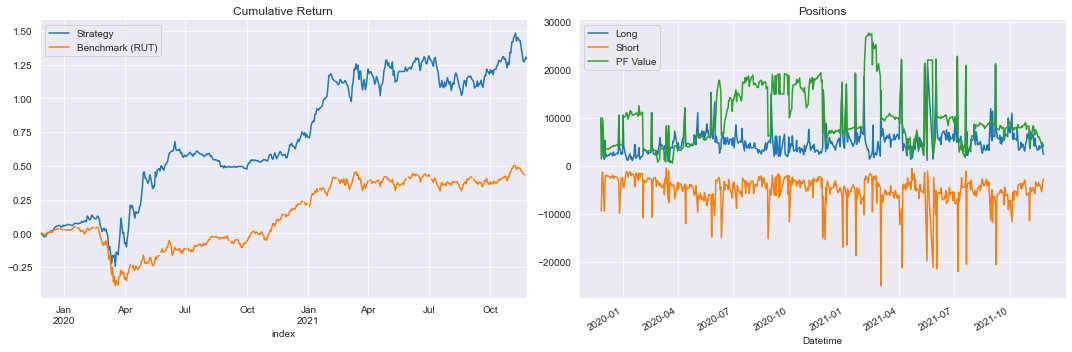

In [69]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

df = returns.to_frame('Strategy').join(bc.to_frame('Benchmark (RUT)'))
df.add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')

longs.plot(label='Long',ax=axes[1], title='Positions')
shorts.plot(ax=axes[1], label='Short')
positions.cash.plot(ax=axes[1], label='PF Value')
axes[1].legend()
sns.despine()
fig.tight_layout();

Start date,2019-11-26
End date,2021-11-23
Total months,23
,Backtest
Annual return,57.321%
Cumulative returns,147.053%
Annual volatility,34.739%
Sharpe ratio,1.48
Calmar ratio,1.73
Stability,0.87
Max drawdown,-33.149%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,33.15,2020-02-12,2020-03-18,2020-04-09,42
1,12.47,2020-06-16,2020-10-01,2020-12-17,133
2,12.23,2021-07-01,2021-08-19,2021-10-20,80
3,9.21,2021-03-15,2021-04-20,2021-04-27,32
4,8.93,2021-02-04,2021-03-08,2021-03-11,26


Stress Events,mean,min,max
New Normal,0.18%,-10.05%,14.04%


Top 10 long positions of all time,max
sid,
MUR,22.68%
ATEC,22.57%
ODP,22.11%
ORC,22.11%
TGI,21.56%
CMRE,21.56%
ABR,21.37%
LADR,21.36%
SITC,21.24%


Top 10 short positions of all time,max
sid,
CDMO,-27.51%
STGW,-24.26%
HSC,-24.02%
MRC,-23.89%
CNR,-23.82%
ENDP,-23.12%
NUS,-22.66%
NBR,-22.58%
TBBK,-22.40%


Top 10 positions of all time,max
sid,
CDMO,27.51%
STGW,24.26%
HSC,24.02%
MRC,23.89%
CNR,23.82%
ENDP,23.12%
MUR,22.68%
NUS,22.66%
NBR,22.58%


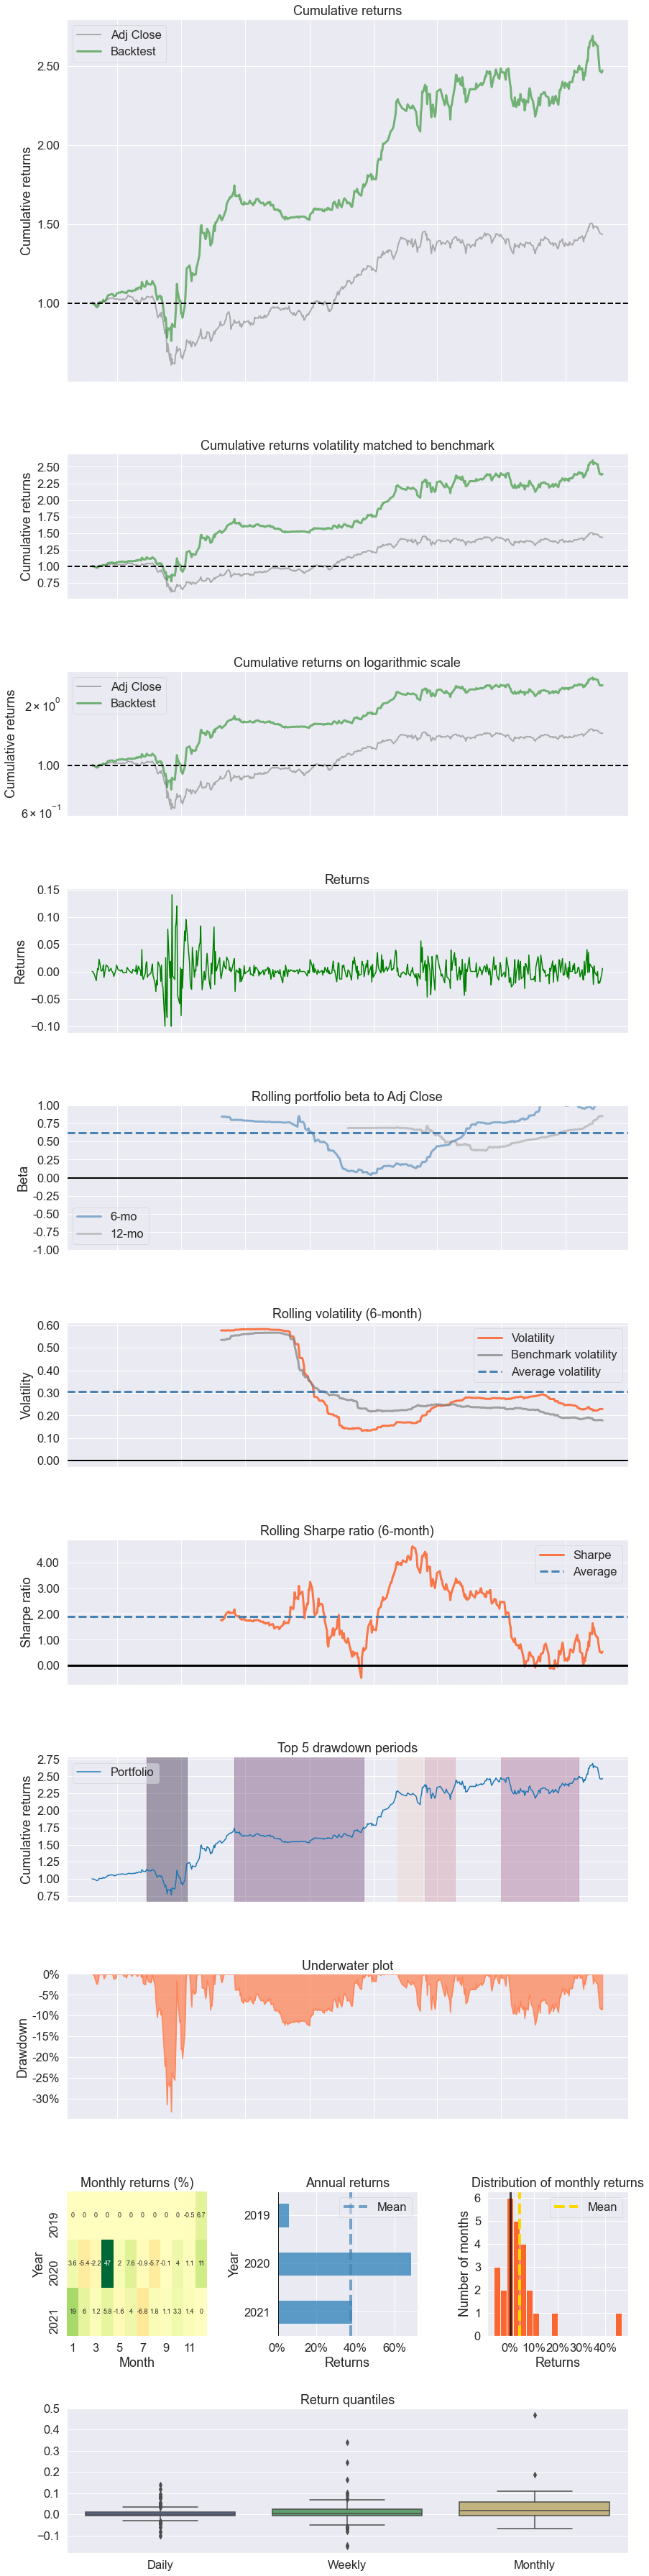

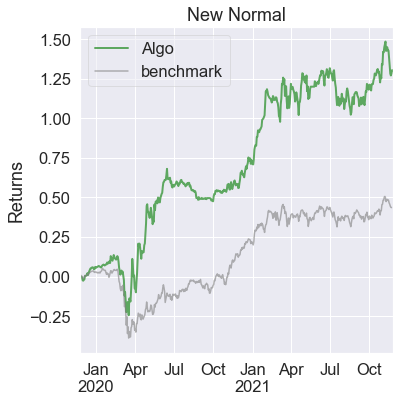

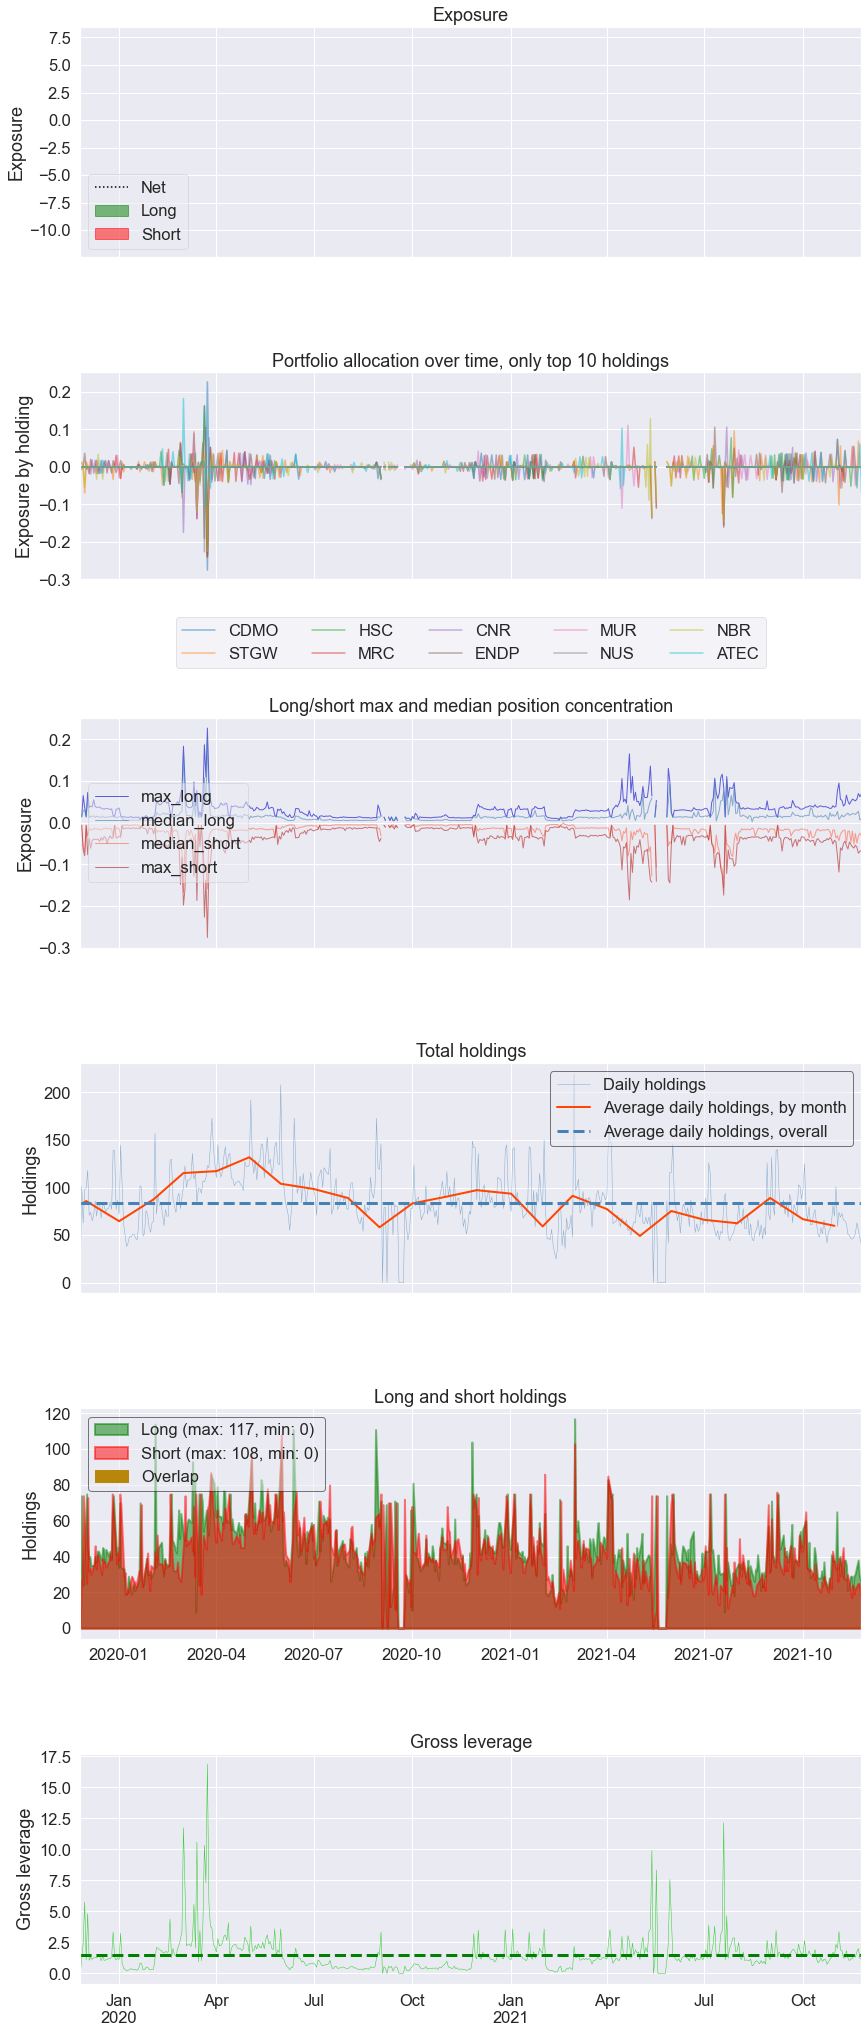

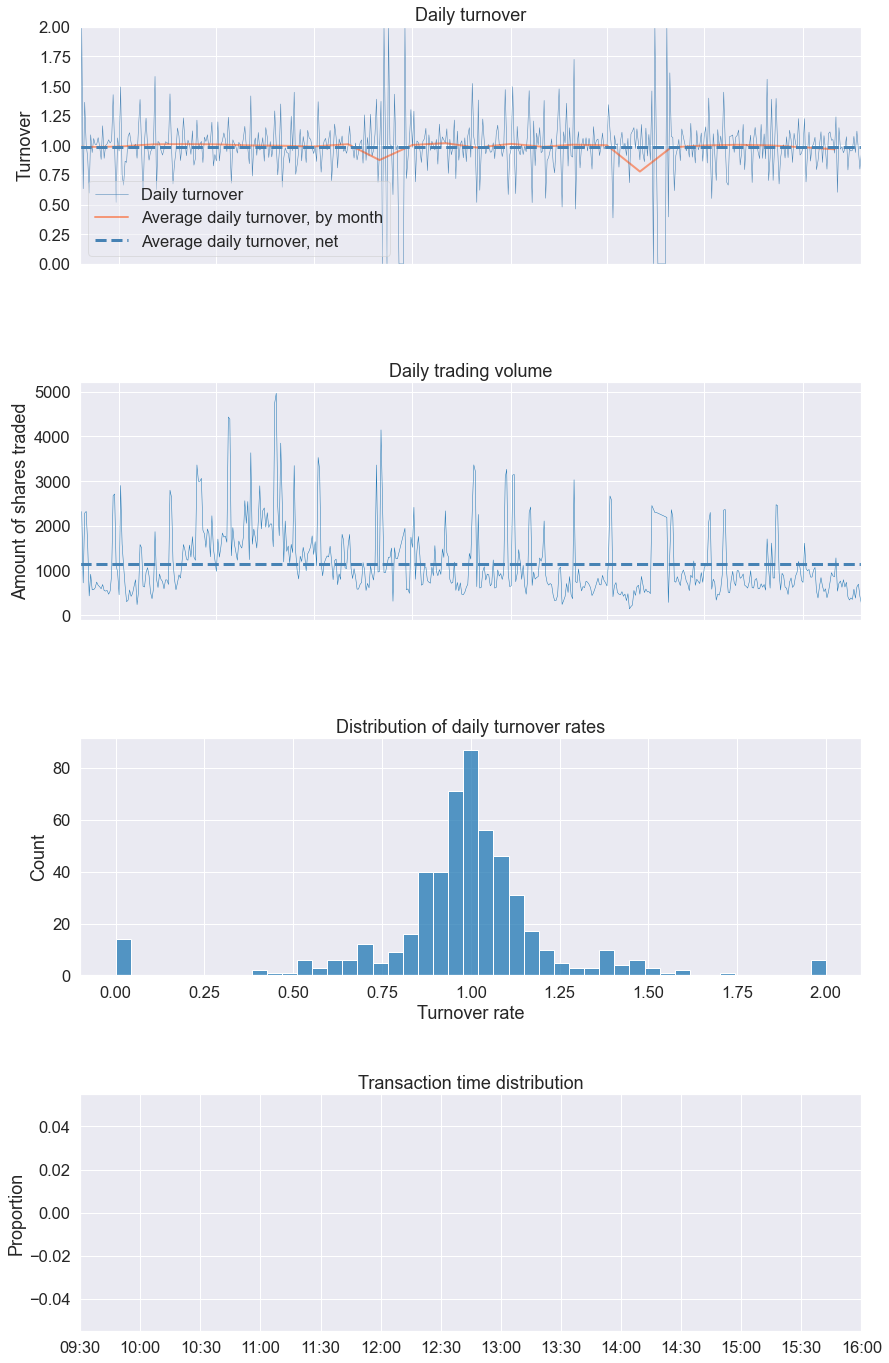

In [70]:
pf.create_full_tear_sheet(returns,
                          transactions=transactions,
                          positions=positions,
                          benchmark_rets=bc.dropna())

In [71]:
# Use this data set to retrieve all the positions that the model created (in order to analyze and see things like which bets had the longest duration or highest returns) 
rts = pf.round_trips.extract_round_trips(transactions, 
                                         portfolio_value=positions.sum(axis='columns') / (returns + 1))

In [72]:
# sort to find the longest trades
rts = rts.sort_values('duration')

In [73]:
rts.iloc[-15:]

,pnl,open_dt,close_dt,long,rt_returns,symbol,duration,returns
11841,11.8300,2021-09-08 00:00:00+00:00,2021-11-09 00:00:00+00:00,True,0.039816,MRC,62 days,-0.000548
7153,36.9700,2021-09-08 00:00:00+00:00,2021-11-10 00:00:00+00:00,True,0.120161,FOSL,63 days,-0.000749
8564,0.2000,2021-09-08 00:00:00+00:00,2021-11-10 00:00:00+00:00,True,0.051680,HLX,63 days,-0.000495
6802,0.7800,2021-09-14 00:00:00+00:00,2021-11-17 00:00:00+00:00,True,0.066553,FGEN,64 days,-0.000429
19509,-24.3200,2021-09-22 00:00:00+00:00,2021-11-25 00:00:00+00:00,False,-0.189320,VICR,64 days,-0.000650
17844,-0.8100,2021-09-08 00:00:00+00:00,2021-11-12 00:00:00+00:00,True,-0.058442,TEN,65 days,0.000521
9228,-1.1500,2021-09-08 00:00:00+00:00,2021-11-15 00:00:00+00:00,True,-0.099138,IDEX,68 days,0.000053
6803,0.5700,2021-09-14 00:00:00+00:00,2021-11-22 00:00:00+00:00,True,0.048635,FGEN,69 days,0.000588
20451,-4.1468,2021-09-09 00:00:00+00:00,2021-11-18 00:00:00+00:00,False,-0.035076,ZD,70 days,-0.000413
6804,0.5700,2021-09-14 00:00:00+00:00,2021-11-25 00:00:00+00:00,True,0.048635,FGEN,72 days,0.000263


In [74]:
rts.loc[rts['symbol']=='CLDX'].sort_values('duration')

,pnl,open_dt,close_dt,long,rt_returns,symbol,duration,returns
3634,0.12,2020-05-27 00:00:00+00:00,2020-05-28 00:00:00+00:00,True,0.046512,CLDX,1 days,-0.000011
3662,-21.01,2021-01-05 00:00:00+00:00,2021-01-06 00:00:00+00:00,True,-0.100632,CLDX,1 days,-0.006566
3655,-8.16,2020-10-26 00:00:00+00:00,2020-10-27 00:00:00+00:00,True,-0.042527,CLDX,1 days,0.005928
3654,-0.72,2020-10-22 00:00:00+00:00,2020-10-23 00:00:00+00:00,True,-0.003617,CLDX,1 days,-0.001678
3652,-13.31,2020-10-08 00:00:00+00:00,2020-10-09 00:00:00+00:00,True,-0.065547,CLDX,1 days,-0.000604
...,...,...,...,...,...,...,...,...
3632,1.50,2020-04-20 00:00:00+00:00,2020-05-21 00:00:00+00:00,True,0.243902,CLDX,31 days,0.001177
3672,-16.16,2021-03-04 00:00:00+00:00,2021-04-05 00:00:00+00:00,True,-0.051107,CLDX,32 days,-0.007883
3633,29.88,2020-04-20 00:00:00+00:00,2020-05-22 00:00:00+00:00,True,0.173862,CLDX,32 days,-0.000034
3676,30.89,2021-04-06 00:00:00+00:00,2021-05-13 00:00:00+00:00,True,0.123048,CLDX,37 days,0.004026


In [75]:
pf.round_trips.print_round_trip_stats(rts)

Summary stats,All trades,Short trades,Long trades
Total number of round_trips,20483.00,10432.00,10051.00
Percent profitable,0.51,0.45,0.58
Winning round_trips,10543.00,4695.00,5848.00
Losing round_trips,9380.00,5426.00,3954.00
Even round_trips,560.00,311.00,249.00


PnL stats,All trades,Short trades,Long trades
Total profit,$20788.59,$-4556.65,$25345.25
Gross profit,$78483.33,$16113.86,$62369.46
Gross loss,$-57694.73,$-20670.51,$-37024.22
Profit factor,$1.36,$0.78,$1.68
Avg. trade net profit,$1.01,$-0.44,$2.52
Avg. winning trade,$7.44,$3.43,$10.67
Avg. losing trade,$-6.15,$-3.81,$-9.36
Ratio Avg. Win:Avg. Loss,$1.21,$0.90,$1.14
Largest winning trade,$226.13,$43.44,$226.13
Largest losing trade,$-194.79,$-83.52,$-194.79


Duration stats,All trades,Short trades,Long trades
Avg duration,5 days 17:00:21.969438070,4 days 02:49:05.705521472,7 days 08:38:29.501542135
Median duration,3 days 00:00:00,3 days 00:00:00,4 days 00:00:00
Longest duration,78 days 00:00:00,70 days 00:00:00,78 days 00:00:00
Shortest duration,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,0.02%,0.02%,0.02%
Avg returns winning,0.12%,0.12%,0.12%
Avg returns losing,-0.10%,-0.10%,-0.09%
Median returns all round_trips,0.00%,0.00%,0.00%
Median returns winning,0.04%,0.04%,0.04%
Median returns losing,-0.03%,-0.03%,-0.03%
Largest winning trade,10.88%,10.88%,7.99%
Largest losing trade,-10.26%,-7.39%,-10.26%


Symbol stats,AAON,AAT,AAWW,ABCB,ABG,ABM,ABR,ACCO,ACIW,ACLS,ACRE,ADC,ADTN,ADUS,AEIS,AEL,AEO,AGEN,AGIO,AGM,AGX,AGYS,AHH,AIMC,AIN,AIR,AIT,AIV,AJRD,AKR,ALE,ALEX,ALGT,ALKS,ALX,AMBA,AMCX,AMKR,AMN,AMOT,AMPH,AMRC,AMRK,AMRS,AMSF,AMSWA,AMWD,ANAT,ANDE,ANF,ANGO,ANIK,ANIP,AOSL,APAM,APOG,APPS,AR,ARCB,ARCT,ARI,ARNA,AROC,AROW,ARR,ARWR,ASB,ASGN,ASPN,ASTE,ATEC,ATEN,ATEX,ATGE,ATI,ATLC,ATNI,ATRA,ATRC,ATRS,ATSG,AUB,AVA,AVAV,AVNS,AVNT,AWR,AZZ,B,BANC,BANF,BANR,BBBY,BBSI,BCC,BCO,BCOR,BCPC,BCRX,BDN,BECN,BFS,BGCP,BGS,BHE,BHLB,BIG,BJRI,BKD,BKE,BKH,BKU,BLFS,BLKB,BLMN,BLUE,BLX,BMI,BMRC,BMTC,BOOM,BOOT,BOX,BRC,BRKL,BSIG,BUSE,BXC,BXMT,BZH,CAC,CADE,CAKE,CAL,CALM,CALX,CARA,CASH,CASS,CATY,CBRL,CBT,CBU,CBZ,CCF,CCMP,CCO,CCOI,CCRN,CCS,CDE,CDMO,CDNA,CDXS,CENT,CENTA,CENX,CERS,CEVA,CFFN,CHCO,CHEF,CHRS,CHS,CHUY,CIM,CIO,CIR,CIT,CLAR,CLDT,CLDX,CLFD,CLNE,CLW,CMC,CMCO,CMP,CMPR,CMRE,CMRX,CMTL,CNK,CNNE,CNO,CNOB,CNR,CNS,CNSL,CNX,CNXN,COHU,COLB,CONN,CORT,COWN,CPE,CPF,CPK,CRAI,CRK,CRMT,CROX,CRS,CRVL,CRY,CSGS,CSII,CSR,CSTM,CSV,CTBI,CTLP,CTRE,CTRN,CTS,CUBI,CUTR,CVBF,CVGW,CVI,CVLT,CWEN/A,CWST,CWT,CXW,CYH,CYTK,DAN,DBD,DBI,DBRG,DCO,DCOM,DDS,DEA,DENN,DGII,DHT,DIN,DIOD,DK,DLX,DMRC,DNOW,DOC,DORM,DRH,DRNA,DRQ,DVAX,DX,DY,EAT,EBIX,EBS,EBTC,ECOL,ECOM,ECPG,EFC,EFSC,EGBN,EGP,EGRX,EHTH,EIG,ELY,EME,ENDP,ENS,ENSG,ENTA,ENV,ENVA,EPAC,EPAY,EPC,EQC,ESE,ESNT,ESRT,ETD,EVC,EVRI,EVTC,EXLS,EXPO,EXTR,FARO,FATE,FBC,FBMS,FBNC,FBP,FC,FCBC,FCF,FCFS,FDP,FELE,FFBC,FFIC,FFIN,FFWM,FGEN,FHI,FIBK,FIX,FIZZ,FLR,FLWS,FMBH,FMBI,FMNB,FN,FOE,FOLD,FOR,FORM,FORR,FOSL,FOXF,FRG,FRME,FRO,FRPH,FSP,FSS,FUL,FULT,FWRD,GABC,GATX,GBL,GBX,GCO,GDEN,GDOT,GEF,GEF/B,GEO,GFF,GIC,GIII,GLDD,GLNG,GLT,GNW,GOGO,GOOD,GPI,GPRE,GPRO,GRC,GRPN,GSAT,GSBC,GT,GTN,GTS,GTY,GVA,GWB,HA,HAE,HAFC,HALO,HASI,HAYN,HBNC,HCCI,HCI,HCKT,HCSG,HEES,HFWA,HI,HIBB,HL,HLIT,HLX,HMHC,HMN,HMST,HNGR,HNI,HOPE,HOV,HP,HQY,HR,HSC,HSII,HSKA,HSTM,HTBK,HTH,HTLD,HTLF,HUBG,HVT,HWC,HWKN,HY,HZO,IBOC,IBP,IBTX,ICFI,IDCC,IDEX,IDT,IESC,IHC,IIVI,IMAX,IMGN,IMKTA,INDB,INDT,INFN,INGN,INN,INO,INSG,INT,INVA,IOSP,IPAR,IPI,IRBT,IRDM,IRMD,IRWD,ISBC,ISEE,ITGR,ITRI,IVR,JACK,JBSS,JBT,JOE,JOUT,JRVR,JW/A,JYNT,KAI,KALU,KAMN,KAR,KBH,KBR,KE,KELYA,KFRC,KFY,KLIC,KMT,KN,KOP,KOS,KPTI,KRA,KRG,KRNY,KRO,KTOS,KW,LADR,LAND,LBAI,LC,LCII,LE,LGF/A,LGIH,LGND,LIND,LIVN,LKFN,LMAT,LNN,LOCO,LPG,LPSN,LQDT,LRN,LSCC,LTC,LXFR,LXP,LZB,M,MAC,MANT,MATW,MATX,MBI,MBUU,MBWM,MC,MCRI,MCS,MD,MDC,MDRX,MDXG,MED,MEI,MGEE,MGLN,MGPI,MGRC,MHO,MITK,MLAB,MLI,MLKN,MMI,MMS,MMSI,MNKD,MNR,MNRO,MOD,MODN,MODV,MOFG,MOG/A,MOV,MRC,MRTN,MSEX,MSTR,MTDR,MTH,MTOR,MTRN,MTSI,MTW,MTX,MUR,MUSA,MWA,MYE,MYGN,MYRG,NAVI,NBHC,NBR,NBTB,NEO,NEOG,NFBK,NG,NHC,NHI,NJR,NMIH,NNI,NOG,NOTV,NP,NPK,NPO,NPTN,NRC,NSIT,NSP,NSSC,NSTG,NTCT,NTGR,NTUS,NUS,NUVA,NVEE,NVRO,NVTA,NWBI,NWE,NWN,NX,NXGN,NXRT,NYMT,OCFC,OCUL,ODP,OEC,OFC,OFG,OFIX,OFLX,OGS,OI,OII,OLP,OMCL,OMI,ONB,OPCH,OPY,ORA,ORC,ORMP,OSBC,OSPN,OSTK,OSUR,OTTR,OUT,OVV,OXM,PACB,PAHC,PAR,PATK,PBF,PBH,PBI,PCH,PCRX,PDCE,PDCO,PDFS,PDM,PEB,PEBO,PETS,PFBC,PFC,PFS,PFSI,PGC,PGRE,PIPR,PLAB,PLAY,PLCE,PLOW,PLUS,PLXS,PMT,PNM,POLY,POR,POWI,PPBI,PRA,PRAA,PRDO,PRFT,PRG,PRGS,PRIM,PRK,PRLB,PRMW,PRO,PRTA,PRTS,PSMT,PTCT,PTEN,PTSI,PZN,PZZA,QCRH,QLYS,QNST,QTWO,QUOT,RAD,RBBN,RBCAA,RC,RCII,RDN,RDNT,REGI,RES,REV,REX,RGP,RGR,RHP,RICK,RIOT,RLGY,RLI,RLJ,RM,RMAX,RMBS,RNST,ROCK,ROIC,RPT,RRC,RRD,RUSHA,RUSHB,RUTH,RVNC,RWT,RYI,SAFT,SAH,SAIA,SANM,SASR,SATS,SBCF,SBGI,SBH,SBRA,SBSI,SCHL,SCHN,SCL,SCS,SCSC,SCU,SCVL,SEAS,SEM,SFL,SFM,SFNC,SGMO,SGMS,SHAK,SHEN,SHO,SHOO,SHYF,SIG,SIGI,SITC,SJI,SJW,SKT,SKYW,SLAB,SLCA,SLP,SM,SMCI,SMP,SMTC,SNBR,SNEX,SP,SPNS,SPNT,SPSC,SPTN,SPWR,SPXC,SR,SRCE,SRDX,SRI,SSB,SSD,SSTK,STAA,STAG,STAR,STBA,STC,STGW,STNG,STRA,STRL,SUM,SWBI,SWM,SWN,SWX,SXC,SXT,SYBT,SYNA,TBBK,TBI,TBK,TBPH,TCBI,TCBK,TCS,TCX,TDS,TEN,TEX,TGH,TGI,TGNA,TGTX,THC,THFF,THR,THRM,THS,TILE,TITN,TMHC,TMP,TMST,TNET,TOWN,TPC,TPH,TR,TREE,TRMK,TRN,TRNO,TRNS,TROX,TRS,TRST,TRTN,TSAT,TSC,TSE,TTEC,TTEK,TTGT,TTMI,TUP,TVTX,TVTY,TWI,TWO,TWOU,TXRH,UBA,UBSI,UCBI,UCTT,UE,UEC,UEIC,UFCS,UFPI,UFPT,UHT,UIS,UMBF,UMH,UNFI,UPLD,URBN,USLM,USM,USNA,USPH,UTL,UUUU,UVE,UVSP,VBTX,VCEL,VCRA,VCYT,VEC,VECO,